In [1]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
import pickle
import seaborn as sb
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
import json
import IO
from sklearn import linear_model
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 
from collections import OrderedDict

def get_int_runs(subject_id, subfolder):
    """
    :param patient_idx:
    :return: list with all run files for the given patient
    """
    os.listdir(settings['out_path'])

    if 'right' in str(subfolder):
        list_subject = [i for i in os.listdir(settings['out_path']) if i.startswith('sub_'+subject_id+'_sess_right') and i.endswith('.p')]
    else:
        list_subject = [i for i in os.listdir(settings['out_path']) if i.startswith('sub_'+subject_id+'_sess_left') and i.endswith('.p')]

    return list_subject

def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps (with downsample_rate=100) in 100ms / need to check with 1375Hz
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]

In [2]:
settings = {}
settings['frequencyranges']=[[4, 8], [8, 12], [13, 20], [20, 35], [13, 35], [60, 80], [90, 200], [60, 200]]
settings['seglengths']=[1, 2, 2, 3, 3, 3, 10, 10, 10]
settings['num_patients']=['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
settings['BIDS_path'] = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\"
settings['out_path'] = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\derivatives\\Int_old_grid\\"
settings['out_path_process'] = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\MOVEMENT DATA\\ECoG_STN\\LM_Time_Analysis_non_CV\\"

In [19]:
laterality=[("CON"), ("IPS")]
signal=["STN", "ECOG"]

for time_stamps in range(10):
    for signal_idx, signal_ in enumerate(signal):
        for sub_idx in np.arange(0, len(settings['num_patients']), 1):
            subject_path=settings['BIDS_path'] + 'sub-' + settings['num_patients'][sub_idx]
            subfolder=IO.get_subfolders(subject_path)
            for sess_idx in range(len(subfolder)):
                X=[]
                Y_con=[]
                Y_ips=[]
                list_subject=get_int_runs(settings['num_patients'][sub_idx], subfolder[sess_idx])
                list_subject=sorted(list_subject)
                print('RUNNIN SUBJECT_'+ settings['num_patients'][sub_idx]+ '_SESS_'+ str(subfolder[sess_idx]) + '_SIGNAL_' + signal_)
                if signal_ == "ECOG":
                    if sub_idx==4 and sess_idx==0: #for sake of comparison with spoc
                        list_subject.pop(0)
                    if sub_idx==4 and sess_idx==1:
                        list_subject.pop(2)

                for run_idx in range(len(list_subject)):
                    with open(settings['out_path']+ '/'+ list_subject[run_idx], 'rb') as handle:
                        run_ = pickle.load(handle)
                    #concatenate features
                    if signal_=="ECOG":
                        ind_cortex=run_['used_channels']['cortex']
                        rf=run_['rf_data_median']
                        x=rf[:,ind_cortex,:]
                        x=np.clip(x, -2,2) # this should have been implemented in the pipeline
                        y=run_['label_baseline_corrected']
                        con_true=run_['label_con_true']
                        y_con=np.squeeze(y[con_true==True])
                        y_ips=np.squeeze(y[con_true==False])
                        X.append(x)
                        Y_con.append(y_con)
                        Y_ips.append(y_ips)
                    else:
                        ind_subcortex=run_['used_channels']['subcortex']
                        if ind_subcortex is not None:

                            rf=run_['rf_data_median']
                            x=rf[:,ind_subcortex,:]
                            x=np.clip(x, -2,2)

                            y=run_['label_baseline_corrected']
                            con_true=run_['label_con_true']
                            y_con=np.squeeze(y[con_true==True])
                            y_ips=np.squeeze(y[con_true==False])

                            X.append(x)
                            Y_con.append(y_con)
                            Y_ips.append(y_ips)

                #gc.collect() # free unreferenced memory

                X=np.concatenate(X, axis=0)
                Y_con=np.concatenate(Y_con, axis=0)
                Y_ips=np.concatenate(Y_ips, axis=0)

                label_= OrderedDict()
                sc_te= OrderedDict()
                Model_coef= OrderedDict()

                for laterality_idx, laterality_ in enumerate(laterality):
                    print("training %s" %laterality_)
                    sc_te[laterality_] = []
                    Model_coef[laterality_] = []
                    label_[laterality_] = []


                    if laterality_=="CON":
                        label=Y_con
                    else:
                        label=Y_ips

                    Score_te=np.empty(X.shape[1], dtype=object)
                    COEF_ = np.empty(X.shape[1],dtype=object)
                    y = np.empty(X.shape[1],dtype=object)

                    #for each electrod
                    for ch_idx in range(X.shape[1]):
                        # rechne hier die CV 
                        # wir sind nur an mean test performance interessiert 
                        # und wichtig, wir wollen weights plotten, getrennt für verschiedene Zeitschritte 

                        # dafür isst aber erstmal wichtig die LM R^2 performance CV rauszukriegen
                        # und zwar ohne Time Concatenation! 
                        x_t, y_t = append_time_dim(X[:, ch_idx, :], label, time_stamps)
                        sc_ = np.nanmean(cross_val_score(linear_model.LinearRegression(), 
                                                x_t, y_t, scoring="r2", cv=5))
                        if sc_ < 0: sc_ = 0             

                        Score_te[ch_idx] = sc_
                        COEF_[ch_idx] = linear_model.LinearRegression().fit(X[:, ch_idx, :], label).coef_
                        y[ch_idx] = label

                    sc_te[laterality_] = Score_te
                    Model_coef[laterality_] = COEF_
                    label_[laterality_] = y

                predict_ = {
                    "score_te": sc_te,
                    "coef" :Model_coef#, 
                    #"X":X,
                    #"y":label_
                }
                if os.path.exists(os.path.join(settings['out_path_process']+ str(time_stamps))) is False: 
                    os.mkdir(os.path.join(settings['out_path_process']+ str(time_stamps)))
                out_path_file = os.path.join(settings['out_path_process']+ str(time_stamps)+"\\"+\
                    settings['num_patients'][sub_idx]+'BestChpredictions_'+signal_+'-'+ str(subfolder[sess_idx])+'.npy')
                np.save(out_path_file, predict_)

ses-right
RUNNIN SUBJECT_000_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_001_SESS_ses-left_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2248, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2248, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(224

training CON
training IPS
RUNNIN SUBJECT_001_SESS_ses-right_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2920, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2920, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(292

training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_004_SESS_ses-left_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3768, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3768, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(376

training CON
training IPS
RUNNIN SUBJECT_004_SESS_ses-right_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3648, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3648, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(364

training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_005_SESS_ses-left_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3096, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3096, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(309

training CON
training IPS
RUNNIN SUBJECT_005_SESS_ses-right_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3544, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3544, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(354

training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_006_SESS_ses-left_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3472, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3472, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(347

training CON
training IPS
RUNNIN SUBJECT_006_SESS_ses-right_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8608, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8608, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(860

training CON
training IPS
ses-left
RUNNIN SUBJECT_007_SESS_ses-left_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2216, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2216, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(221

training CON
training IPS
ses-left
RUNNIN SUBJECT_008_SESS_ses-left_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2776, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2776, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(277

training CON
training IPS
ses-left
RUNNIN SUBJECT_009_SESS_ses-left_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2648, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2648, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(264

training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_010_SESS_ses-left_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(472, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(472, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(472, 

training CON
training IPS
RUNNIN SUBJECT_010_SESS_ses-right_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2656, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2656, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(265

training CON
training IPS
ses-left
RUNNIN SUBJECT_013_SESS_ses-left_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2968, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2968, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(296

training CON
training IPS
ses-right
RUNNIN SUBJECT_014_SESS_ses-right_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2152, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2152, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(215

training CON
training IPS
ses-right
RUNNIN SUBJECT_000_SESS_ses-right_SIGNAL_ECOG


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2104, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2104, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(210

training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_001_SESS_ses-left_SIGNAL_ECOG


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(6056, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(6056, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(605

training CON


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(9336, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(9336, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(933

C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(9336, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(9336, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(933

training IPS


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(9336, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(9336, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(933

RUNNIN SUBJECT_001_SESS_ses-right_SIGNAL_ECOG
training CON


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8768, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8768, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(876

C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8768, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8768, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(876

C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8768, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8768, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(876

training IPS


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8768, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8768, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(876

C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8768, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8768, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(876

ses-left
ses-right
RUNNIN SUBJECT_004_SESS_ses-left_SIGNAL_ECOG
training CON
training IPS
RUNNIN SUBJECT_004_SESS_ses-right_SIGNAL_ECOG


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3648, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3648, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(364

training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_005_SESS_ses-left_SIGNAL_ECOG


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(4576, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(4576, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(457

training CON
training IPS
RUNNIN SUBJECT_005_SESS_ses-right_SIGNAL_ECOG


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(7792, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(7792, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(779

training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_006_SESS_ses-left_SIGNAL_ECOG


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3472, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3472, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(347

training CON


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(6384, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(6384, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(638

C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(6384, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(6384, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(638

C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(6384, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(6384, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(638

training IPS


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(6384, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(6384, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(638

C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(6384, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(6384, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(638

RUNNIN SUBJECT_006_SESS_ses-right_SIGNAL_ECOG
training CON


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8856, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8856, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(885

C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8856, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8856, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(885

C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8856, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8856, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(885

training IPS


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8856, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8856, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test parti

C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8856, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(8856, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(885

ses-left
RUNNIN SUBJECT_007_SESS_ses-left_SIGNAL_ECOG
training CON


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2776, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(2776, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(277

training IPS
ses-left
RUNNIN SUBJECT_008_SESS_ses-left_SIGNAL_ECOG
training CON
training IPS
ses-left
RUNNIN SUBJECT_009_SESS_ses-left_SIGNAL_ECOG


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(5184, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(5184, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(518

training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_010_SESS_ses-left_SIGNAL_ECOG


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(6232, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(6232, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(623

training CON
training IPS


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(11032, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(11032, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(1

RUNNIN SUBJECT_010_SESS_ses-right_SIGNAL_ECOG
training CON
training IPS
ses-left
RUNNIN SUBJECT_013_SESS_ses-left_SIGNAL_ECOG


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(5456, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(5456, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(545

training CON
training IPS
ses-right
RUNNIN SUBJECT_014_SESS_ses-right_SIGNAL_ECOG


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3944, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(3944, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(394

training CON
training IPS
ses-right
RUNNIN SUBJECT_000_SESS_ses-right_SIGNAL_STN


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(5904, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(5904, 0)) while a minimum of 1 is required.

  FitFailedWarning)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(590

training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_001_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_001_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_004_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_004_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_005_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_005_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_006_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_006_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-left
RUNNIN SUBJECT_007_SESS_ses-left_SIGNAL_STN
training CON
training IPS
ses-left
RUNNIN SUBJECT_008_SESS_ses-left_SIGNAL_STN
training CON
training IPS
ses-left
RUNNIN SUBJECT_009_SESS_ses-left_SIGNAL_STN
training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_010_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN S

training IPS
ses-left
ses-right
RUNNIN SUBJECT_006_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_006_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-left
RUNNIN SUBJECT_007_SESS_ses-left_SIGNAL_STN
training CON
training IPS
ses-left
RUNNIN SUBJECT_008_SESS_ses-left_SIGNAL_STN
training CON
training IPS
ses-left
RUNNIN SUBJECT_009_SESS_ses-left_SIGNAL_STN
training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_010_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_010_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-left
RUNNIN SUBJECT_013_SESS_ses-left_SIGNAL_STN
training CON
training IPS
ses-right
RUNNIN SUBJECT_014_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-right
RUNNIN SUBJECT_000_SESS_ses-right_SIGNAL_ECOG
training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_001_SESS_ses-left_SIGNAL_ECOG
training CON
training IPS
RUNNIN SUBJECT_001_SESS_ses-right_SIGNAL_ECOG
training CON
training IPS
ses-left
ses-right
RUNNIN 

KeyboardInterrupt: 

In [3]:
def get_performance(loc_="ECOG", mod_="CON"):
    res_time =[]
    for time_stamps in range(8):
        settings['out_path_process']
        res_ = []
        for sub_idx in np.arange(0, len(settings['num_patients']), 1):
            sess  = [f for f in os.listdir(os.path.join(settings["out_path_process"], str(time_stamps)))
                         if (loc_ in f) and settings["num_patients"][sub_idx] in f] 
            per_ = []; coef_ = []
            for sess_ in sess:
                dat = np.load(os.path.join(os.path.join(settings["out_path_process"], str(time_stamps)), sess_), allow_pickle=True).tolist()
                per_.append(dat["score_te"][mod_])
                coef_.append(dat["coef"][mod_])
            res_.append(np.max(np.concatenate(per_)))
        res_time.append(res_)
    return np.array(res_time)

In [4]:
def my_boxplot(alpha_con, alpha_ips):
    data_a = alpha_con
    data_b = alpha_ips
    ticks = [str(i) for i in range(len(alpha_con))]

    bpl = plt.boxplot(data_a, positions=np.array(range(len(ticks)))*2.0-0.4, widths=0.6, patch_artist=True, showmeans=True)
    bpr = plt.boxplot(data_b, positions=np.array(range(len(ticks)))*2.0+0.4, widths=0.6, patch_artist=True, showmeans=True)
    set_box_color(bpl, 'red') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'blue')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='red', label='contralateral')
    plt.plot([], c='blue', label='ipsilateral')
    plt.xticks(range(0, len(ticks) * 2, 2), ['alpha', 'theta', 'low beta', 'high beta', 'all beta', \
                        'low gamma', 'high gamma', 'all gamma'], rotation=45)
    plt.xlim(-2, len(ticks)*2)
    plt.xlabel('patient')
    plt.tight_layout()
def set_box_color(bp, color):
    #plt.setp(bp['boxes'], color='black')
    #plt.setp(bp['whiskers'], color='black')
    #plt.setp(bp['caps'], color='black')
    plt.setp(bp['medians'], color='black')
    l_ = []
    l_.append(color)
    l_ = l_*len(bp['boxes']) 
    for patch, color_ in zip(bp['boxes'], l_):
        patch.set_facecolor(color_)
    

In [25]:
ECOG_con = list(get_performance(loc_="ECOG", mod_="CON"))
ECOG_ips = list(get_performance(loc_="ECOG", mod_="IPS"))
STN_con = list(get_performance(loc_="STN", mod_="CON"))
STN_ips = list(get_performance(loc_="STN", mod_="IPS"))

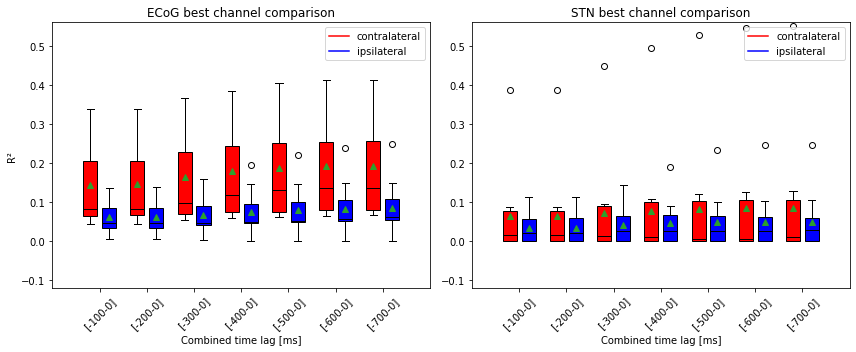

In [6]:
plt.figure(figsize=(12,5))#, dpi=300)
plt.subplot(121)
my_boxplot(ECOG_con, ECOG_ips)
NUM_ticks= 7
plt.xticks(range(0, NUM_ticks * 2, 2), \
           ['[-100-0]', '[-200-0]', '[-300-0]', '[-400-0]', '[-500-0]', '[-600-0]', '[-700-0]'], rotation=45)

#plt.gca().invert_xaxis()
plt.xlabel('Combined time lag [ms]')
plt.ylim(-0.12, 0.56)
plt.ylabel('R²')
plt.legend(loc='upper right')
plt.title('ECoG best channel comparison')
#plt.grid(True)
plt.subplot(122)
my_boxplot(STN_con, STN_ips)
plt.xticks(range(0, NUM_ticks * 2, 2), \
           ['[-100-0]', '[-200-0]', '[-300-0]', '[-400-0]', '[-500-0]', '[-600-0]', '[-700-0]'], rotation=45)

#plt.gca().invert_xaxis()
plt.xlabel('Combined time lag [ms]')
plt.ylim(-0.12, 0.56)
#plt.ylabel('R²')
plt.legend(loc='upper right')
plt.title('STN best channel comparison')
plt.tight_layout()
#plt.grid(True)

### Repeat plot using Seaborn

In [21]:
get_performance(loc_="ECOG", mod_="CON").shape

(7, 11)

In [26]:
# transform data to dataframe 
lags = ['[-100-0]', '[-200-0]', '[-300-0]', '[-400-0]', '[-500-0]', '[-600-0]', '[-700-0]']
df = pd.DataFrame()
for loc in ["ECOG", "STN"]:
    for lat in ["CON", "IPS"]:
        data_ = get_performance(loc_=loc, mod_=lat)
        for patient in range(11):
            for lag in range(7):
                df = df.append({
                    "Combined time lag [ms]":lags[lag],
                    "patient":patient,
                    r"$R^2$":data_[lag+1, patient],
                    "loc":loc,
                    "lat":lat
                },ignore_index=True)

In [5]:
df = pd.read_pickle("df_WF_T_concat.p")

In [6]:
df

,$R^2$,Combined time lag [ms],lat,loc,patient
0,0.337804,[-100-0],CON,ECOG,0.0
1,0.367773,[-200-0],CON,ECOG,0.0
2,0.384219,[-300-0],CON,ECOG,0.0
3,0.404913,[-400-0],CON,ECOG,0.0
4,0.411794,[-500-0],CON,ECOG,0.0
...,...,...,...,...,...
303,0.000000,[-300-0],IPS,STN,10.0
304,0.000000,[-400-0],IPS,STN,10.0
305,0.000000,[-500-0],IPS,STN,10.0
306,0.000000,[-600-0],IPS,STN,10.0


In [7]:
#plt.style.use('dark_background')
params = {'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

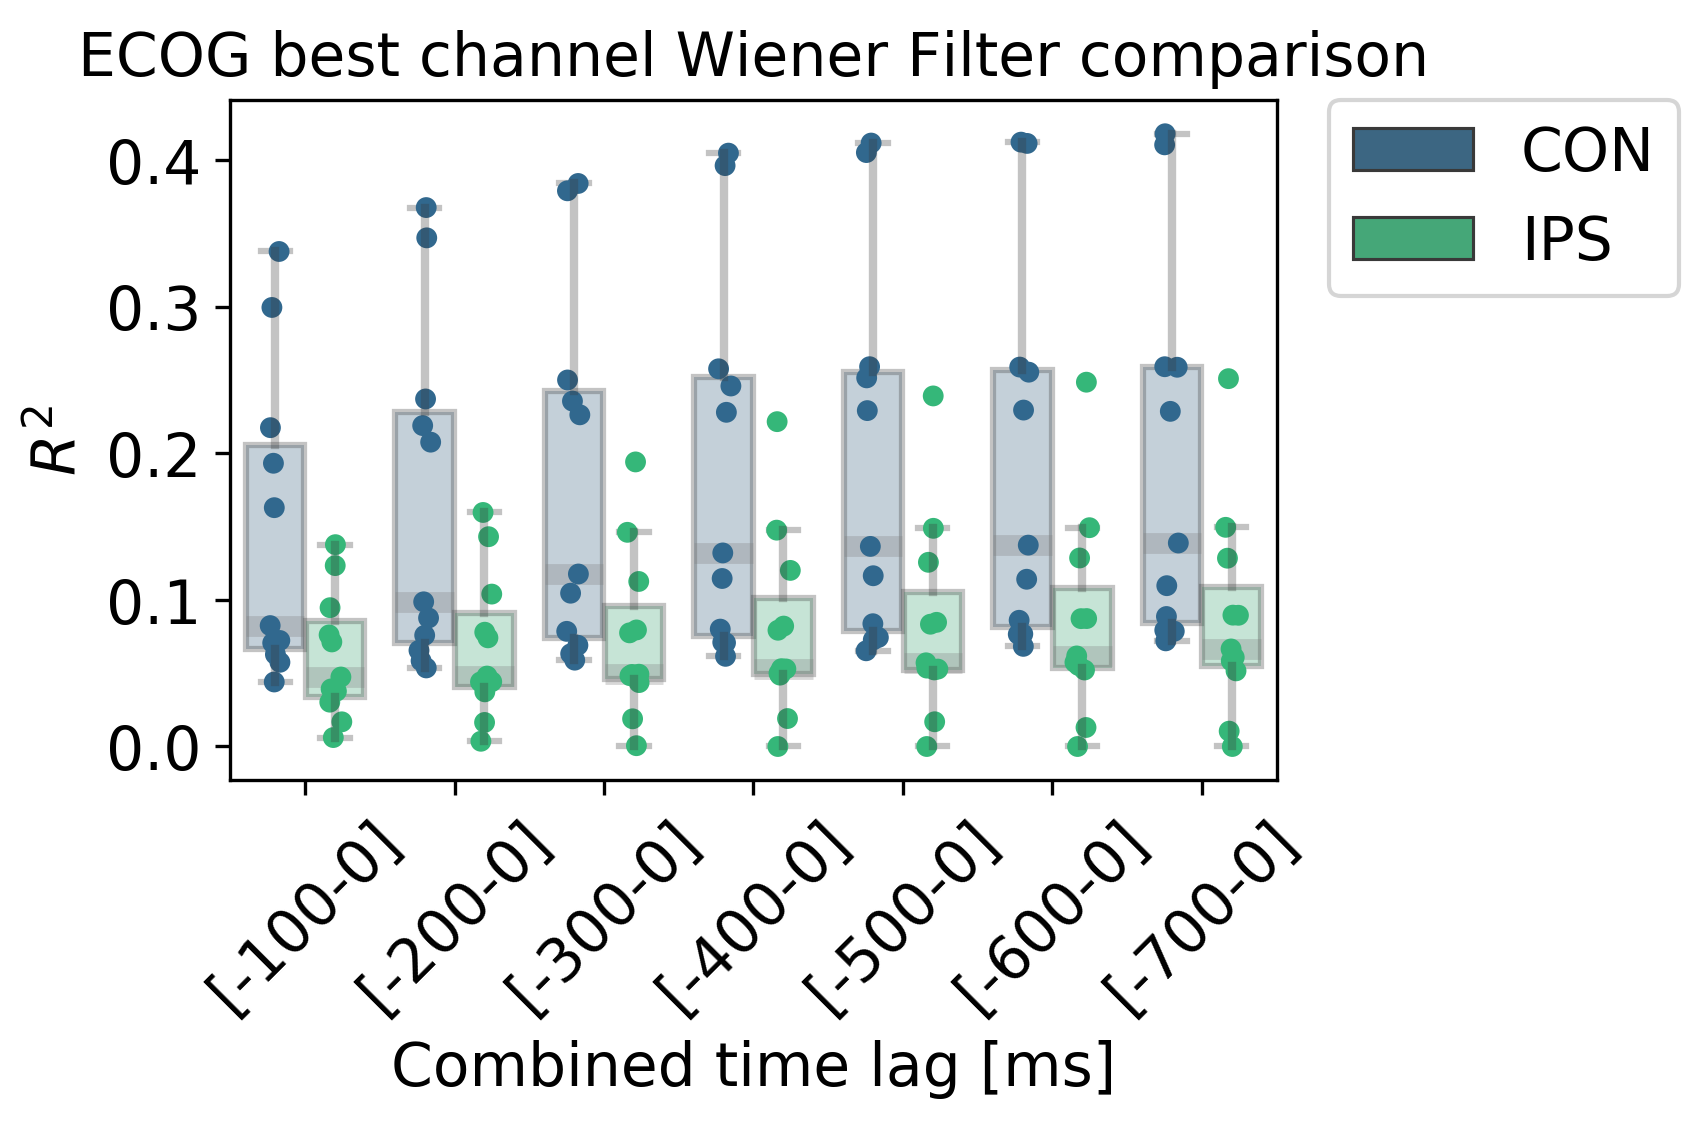

In [8]:
alpha_box = 0.3
plt.figure(figsize=(4.5,3), dpi=300)
sb.boxplot(x="Combined time lag [ms]", y=r"$R^2$", hue="lat", #order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
           data=df[df["loc"] == "ECOG"], palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))
ax = sb.stripplot(x="Combined time lag [ms]", y=r"$R^2$", hue="lat", #order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
             data=df[df["loc"] == "ECOG"],palette="viridis", dodge=True, s=5)


# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("ECOG best channel Wiener Filter comparison")
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

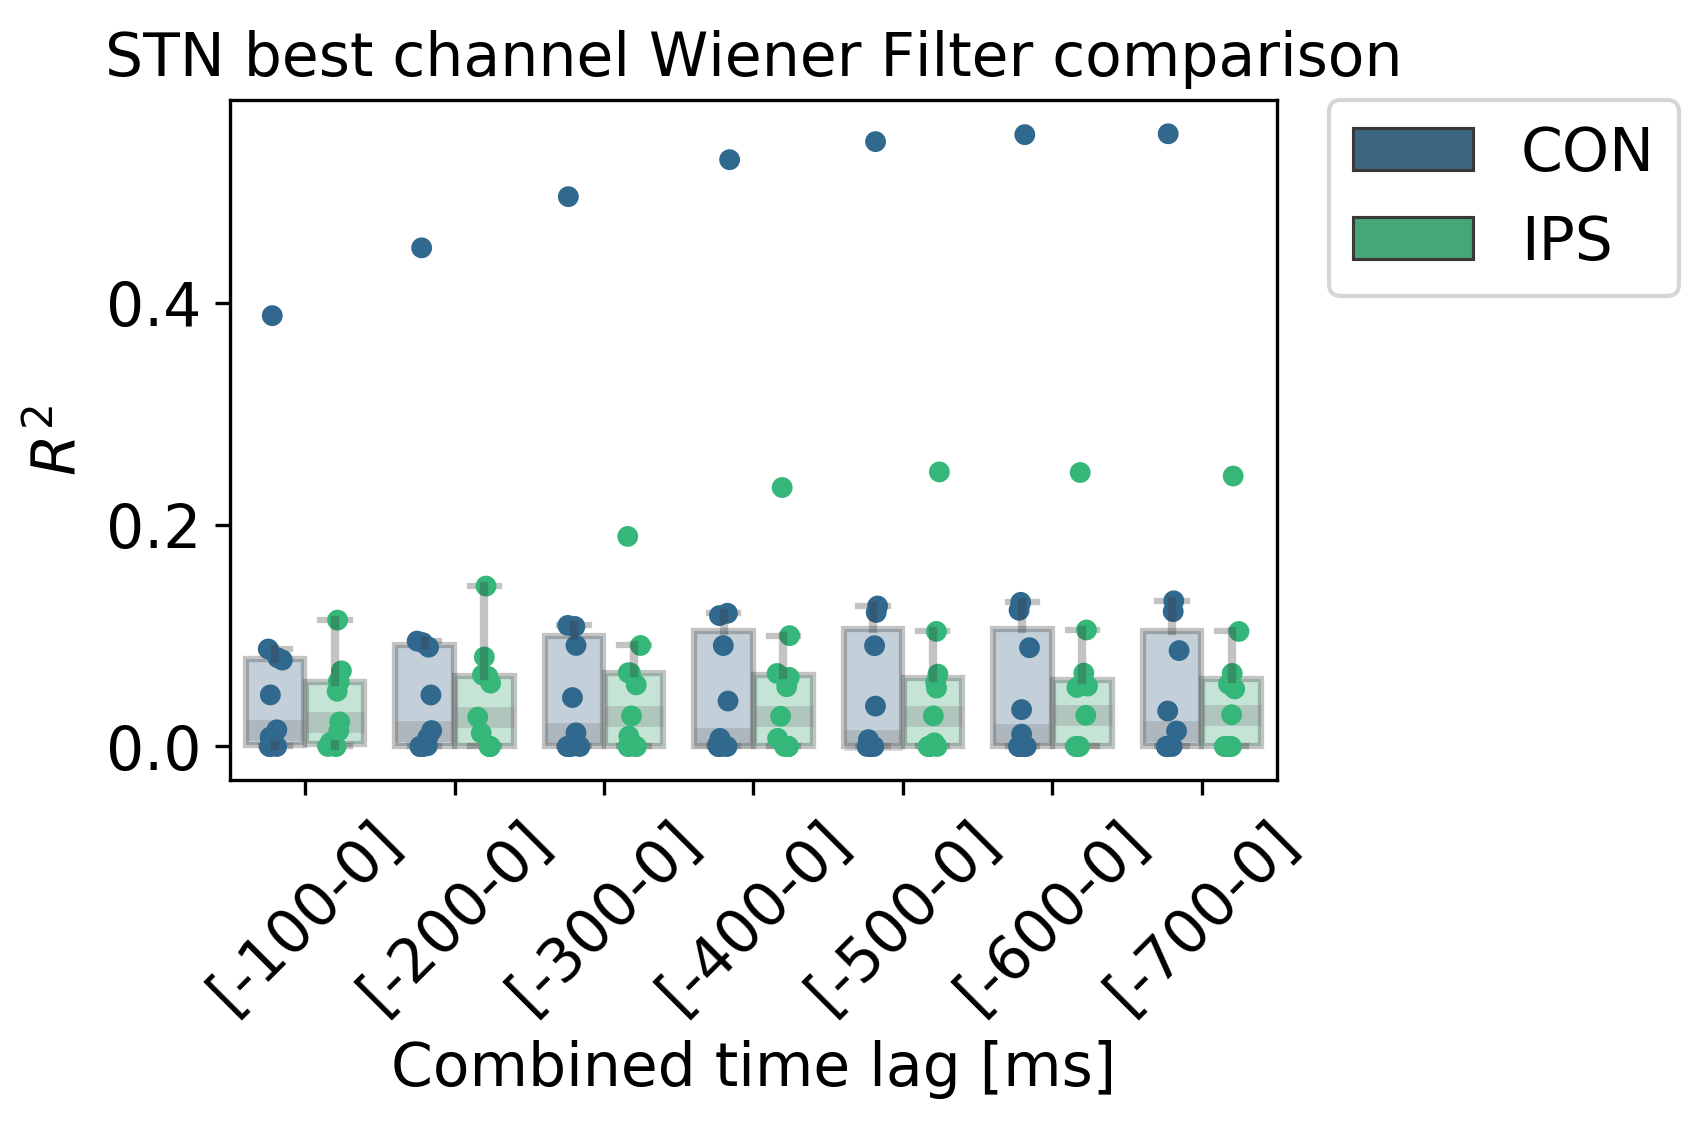

In [9]:
alpha_box = 0.3
plt.figure(figsize=(4.5,3), dpi=300)
sb.boxplot(x="Combined time lag [ms]", y=r"$R^2$", hue="lat", #order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
           data=df[df["loc"] == "STN"], palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))
ax = sb.stripplot(x="Combined time lag [ms]", y=r"$R^2$", hue="lat", #order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
             data=df[df["loc"] == "STN"],palette="viridis", dodge=True, s=5)


# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("STN best channel Wiener Filter comparison")
plt.xticks(rotation=45)

In [30]:
df.to_pickle("df_WF_T_concat.p")